<a href="https://colab.research.google.com/github/stefanogiagu/corso_AI_2024/blob/main/notebooks/es8/MetodiAI_Fis2024_Es8_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercitazione 8: implementazione in pytorch di una rete neurale fully connected, addestrata per task di classificazione e regressione

**Scopo:** familiarizzare con l'implementazione di ANN con la libreria pytorch

**Dataset:** Sloan Digital Sky Survey Dataset

In [ ]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

# pytorch
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [ ]:
# download del dataset
!rm -rf star_classification.csv
!wget http://giagu.web.cern.ch/giagu/CERN/star_classification.csv

--2024-04-28 18:41:09--  http://giagu.web.cern.ch/giagu/CERN/star_classification.csv
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.184.21.205, 2001:1458:d00:34::100:59
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.184.21.205|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16755863 (16M) [text/csv]
Saving to: ‘star_classification.csv’

star_classification 100%[===================>]  15.98M  8.37MB/s    in 1.9s    

2024-04-28 18:41:11 (8.37 MB/s) - ‘star_classification.csv’ saved [16755863/16755863]



Il dataset consiste in 100000 osservazioni dello spazio effettuate dal SDSS (Sloan Digital Sky Survey). Ogni osservazione è descritta da 17 colonne di caratteristiche e 1 colonna di classe (*'class'*) che la identifica come stella (*'STAR'*), galassia (*'GALAXY'*) o quasar (*'QSO'*)

Vogliamo allenare due reti neurali di tipo MLP, una per predire la classe a partire dalle 11 colonne (*'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'redshift', 'plate', 'MJD'*) (classificazione), e una per predire il target *'redshift'* a partire dalle 10 colonne (*'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'plate', 'MJD'*) (regressione).

Contenuto delle colonne del df:

1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


In [ ]:
# importa in un dataframe pandas il dataset
df = pd.read_csv('star_classification.csv')
display(df)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [ ]:
# printa il numero di esempi in cascuna classe (GALAXY, STAR, Q (QUASAR))
display(df['class'].value_counts())
df['class'].value_counts(normalize=True).to_frame().style.bar(color='green')

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

,proportion
class,
GALAXY,0.594450
STAR,0.215940
QSO,0.189610


In [ ]:
# trasforma label da string a indice numerico intero (0,1,2)
from sklearn import preprocessing

LE = preprocessing.LabelEncoder()
df['class'] = LE.fit_transform(df['class'])
df['class'].value_counts()

class
0    59445
2    21594
1    18961
Name: count, dtype: int64

In [ ]:
# calcola pesi per ribilanciare le classi (da usare con la loss BinaryCrossEntropy)

# peso_classe_i = N_tot / (N_classi * N_i) con N_tot # totale eventi,  N_classi #classi,  N_i # eventi nella classe i-esima

cls_w = []
allev = sum(df['class'].value_counts())
for i in range(3):
  cls_w.append(allev/(3*df['class'].value_counts()[i]))
print(cls_w)

[0.5607424229680097, 1.757994479897333, 1.5436386650612826]


In [ ]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [ ]:
# seleziona solo le variabili utili

# per il task di classificazione usiamo come feature 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift' - e come label "class"
x_cls = df.drop(['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'plate', 'MJD', 'fiber_ID'], axis = 1).values
y_cls = df['class'].values

# per il task di regressione usiamo come feature 'alpha', 'delta', 'u', 'g', 'r', 'z'  - e come target una funzione non lineare di tali misure (solo per scopi didattici)
x_reg = df.drop(['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'i', 'redshift', 'plate', 'MJD', 'fiber_ID'], axis = 1).values

y_reg = 10 * np.sin(np.pi * x_reg[:,0] * x_reg[:,1]) + 20 * (x_reg[:,2] - 0.5) ** 2 + 10 * x_reg[:,3] + 5 * x_reg[:,4] + 2*x_reg[:,5]

# eliminiamo valori troppo grandi generati dalla funzione scelta che potrebbero rendere instabile il training:

x_reg = x_reg[y_reg<20000]
y_reg = y_reg[y_reg<20000]
y_reg = y_reg.reshape((-1,1))

print(x_cls.shape)
print(y_cls.shape)
print(x_reg.shape)
print(y_reg.shape)

(100000, 8)
(100000,)
(99998, 6)
(99998, 1)


In [ ]:
# Preprocessamento del dataset

# divisione in train, validation e test dataset (33:33:33)
from sklearn.model_selection import train_test_split

x_cls_train,x_cls_test,y_cls_train,y_cls_test = train_test_split(x_cls , y_cls , test_size=0.33, shuffle=True, random_state=0)
x_cls_train,x_cls_vali,y_cls_train,y_cls_vali = train_test_split(x_cls_train , y_cls_train , test_size=0.5, shuffle=True, random_state=0)
print(x_cls_train.shape)
print(x_cls_vali.shape)
print(x_cls_test.shape)

x_reg_train,x_reg_test,y_reg_train,y_reg_test = train_test_split(x_reg , y_reg , test_size=0.33, shuffle=True, random_state=0)
x_reg_train,x_reg_vali,y_reg_train,y_reg_vali = train_test_split(x_reg_train , y_reg_train , test_size=0.5, shuffle=True, random_state=0)
print(x_reg_train.shape)
print(x_reg_vali.shape)
print(x_reg_test.shape)

(33500, 8)
(33500, 8)
(33000, 8)
(33499, 6)
(33499, 6)
(33000, 6)


**Normalizzazione delle fetaure in input**: normalizzare l'input permette di usare learnign rate più grandi (e quindi effetturare un training più veloce) oltre a stabilizzare l'addestramento ...

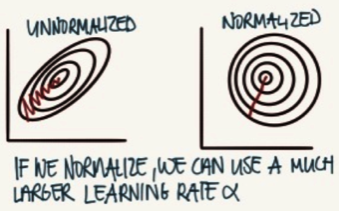

In [ ]:
# normalizzazione (x-mu)/sdev

# per evitare possibile passaggio di informazione dal dataset di test in quello di training è preferibile normalizzare tutti i dataset
# o usando i parametri del solo traingin dataset, oppure indipendentemente uno dall'altro

# normalizzaiamo i dataset indipendentemente uno dall'altro
sc_cls_train = preprocessing.StandardScaler()
sc_cls_vali = preprocessing.StandardScaler()
sc_cls_test = preprocessing.StandardScaler()

x_cls_train = sc_cls_train.fit_transform(x_cls_train)
x_cls_vali = sc_cls_vali.fit_transform(x_cls_vali)
x_cls_test = sc_cls_test.fit_transform(x_cls_test)

# alternativamente:
# x_cls_train = sc_cls_train.fit_transform(x_cls_train)
# x_cls_vali = sc_cls_train.transform(x_cls_vali)
# x_cls_test = sc_cls_train.transform(x_cls_test)


sc_reg_train = preprocessing.StandardScaler()
sc_reg_vali = preprocessing.StandardScaler()
sc_reg_test = preprocessing.StandardScaler()


x_reg_train = sc_reg_train.fit_transform(x_reg_train)
x_reg_vali = sc_reg_vali.fit_transform(x_reg_vali)
x_reg_test = sc_reg_test.fit_transform(x_reg_test)

# eliminiamo valori troppo grandi

# per la task di regressione per la funzione scelta il range di variazione del target è molto ampio e questo può
# rendere instabile il training. Conviene noralizzare il target tra -1 e 1

#y_reg_train = 2*y_reg_train - np.min(y_reg_train))/(np.max(y_reg_train)-np.min(y_reg_train))-1.0
#y_reg_vali = 2*y_reg_vali - np.min(y_reg_vali))/(np.max(y_reg_vali)-np.min(y_reg_vali))-1.0
#y_reg_test = 2*y_reg_test - np.min(y_reg_test))/(np.max(y_reg_test)-np.min(y_reg_test))-1.0

In [ ]:
# conversione in tensori torch dei vettori numpy

x_cls_train_pt = torch.Tensor(x_cls_train).float()
y_cls_train_pt = torch.Tensor(y_cls_train).long() #cuda vuole long int per le label
x_cls_vali_pt = torch.Tensor(x_cls_vali).float()
y_cls_vali_pt = torch.Tensor(y_cls_vali).long()
x_cls_test_pt = torch.Tensor(x_cls_test).float()
y_cls_test_pt = torch.Tensor(y_cls_test).long()

print(x_cls_train_pt.shape)
print(y_cls_train_pt.shape)
print(x_cls_vali_pt.shape)
print(y_cls_vali_pt.shape)
print(x_cls_test_pt.shape)
print(y_cls_test_pt.shape)

x_reg_train_pt = torch.Tensor(x_reg_train).float()
y_reg_train_pt = torch.Tensor(y_reg_train).float()
x_reg_vali_pt = torch.Tensor(x_reg_vali).float()
y_reg_vali_pt = torch.Tensor(y_reg_vali).float()
x_reg_test_pt = torch.Tensor(x_reg_test).float()
y_reg_test_pt = torch.Tensor(y_reg_test).float()


print(x_reg_train_pt.shape)
print(y_reg_train_pt.shape)
print(x_reg_vali_pt.shape)
print(y_reg_vali_pt.shape)
print(x_reg_test_pt.shape)
print(y_reg_test_pt.shape)

torch.Size([33500, 8])
torch.Size([33500])
torch.Size([33500, 8])
torch.Size([33500])
torch.Size([33000, 8])
torch.Size([33000])
torch.Size([33499, 6])
torch.Size([33499, 1])
torch.Size([33499, 6])
torch.Size([33499, 1])
torch.Size([33000, 6])
torch.Size([33000, 1])


Uso della GPU. Se si ha a disposizione una GPU può essere utilizzata per accelerare le operazioni. Questo richiede di spostare i tensori e il modello di rete neurale sulla GPU quando si effettuano i calcoli. È conveniente controllare se la GPU è disponibile e nel caso settare una variabile opportuna per l'uso successivo.

In [ ]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [ ]:
# per allenare la rete neurale con SGD (stochastic gradient descent), dobbiamo dividere
# il campione di training in mini batch, e eventualmente fare un reshuffling degli eventi ad ongi epoca,
# applicare trasformazioni etc...

# questo viene fatto in pytorch automaticamente tramite delle helper function chiamate
# Data Sets e Data Loaders

# pytorch dataset: premette di accoppiare fietaure e target per ogni evento e di accedere ad ogni coppia del
# dataset

# pytorch dataloader permette di costruire un iterabile python e applicare divisione in mini-batch, shuffling,
# uso di multiprocessing per leggere i dati, applicare data augmentation, etc....

from torch.utils.data import TensorDataset, DataLoader

batch = 128


# dataset per classificazione
ds_cls_train = TensorDataset(x_cls_train_pt, y_cls_train_pt) # a datset are pair of feature tensor, target tensor
dl_cls_train = DataLoader(ds_cls_train, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)  #the dataset will be shuffled and batched in mini batch of batch event each

ds_cls_vali = TensorDataset(x_cls_vali_pt, y_cls_vali_pt)
dl_cls_vali = DataLoader(ds_cls_vali, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

ds_cls_test = TensorDataset(x_cls_test_pt, y_cls_test_pt)
dl_cls_test = DataLoader(ds_cls_test, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

# dataset per regressione
ds_reg_train = TensorDataset(x_reg_train_pt, y_reg_train_pt) # a datset are pair of feature tensor, target tensor
dl_reg_train = DataLoader(ds_reg_train, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)  #the dataset will be shuffled and batched in mini batch of batch event each

ds_reg_vali = TensorDataset(x_reg_vali_pt, y_reg_vali_pt)
dl_reg_vali = DataLoader(ds_reg_vali, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

ds_reg_test = TensorDataset(x_reg_test_pt, y_reg_test_pt)
dl_reg_test = DataLoader(ds_reg_test, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

In [ ]:
# ogni data loader fornisce un iteratore con il quale si possono accedere ai vari mini-batch del dataset

feat, label = next(iter(dl_cls_train))

print(f"Feature batch shape: {feat.size()}")
print(f"Labels batch shape: {label.size()}")

Feature batch shape: torch.Size([128, 8])
Labels batch shape: torch.Size([128])


### Definzione del modello di rete neurale per la classificazione.

Archiettura: MLP con layer densi (Linear in pytorch):
 con 2 layer hidden con attivazioni ReLU, e 3 neuroni di output con attivazione softmax che predicono la probabilità che l'input appartenga ad una delle 3 classi possibili:

*   input layer: 8 neuroni (la dimensione del vettore di input x)
*   primo hidden layer: 128 neuroni, attivazione ReLU
*   secondo hidden layer: 128 neuroni, attivazione ReLU
*   output layer: 3 neuroni, attivazione softmax

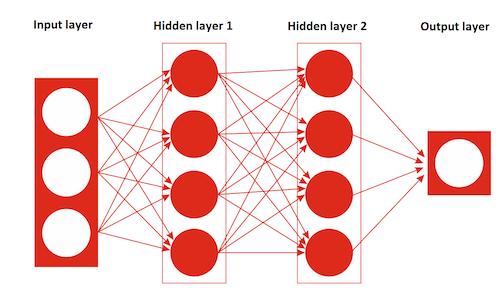

In [ ]:
from torch import nn
import torch.nn.functional as F

# in pytorch una rete neurale viene implementata costruendo una classe python che eredita
# dalla classe di pytorch nn.Module e implementa due metodi di base:
# __init__: definizione dei layer utlizzati
# forward: funzione che calcola y = ANN(x)

class ShallowMLP(nn.Module):
  def __init__(self, input_dim=8, output_dim=3, hidden_dim=128):
    super(ShallowMLP, self).__init__()

    # inizializzazione dei layer/funzioni che utilizzeremo per definire la rete

    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    self.layer1 = nn.Linear(input_dim, hidden_dim)  #hidden layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)
    self.layer3 = nn.Linear(hidden_dim, output_dim) #output layer

    self.relu = nn.ReLU() # relu function (NOTA: non è obbligatorio definirla qui, è anche possible usare la forma funzionale F.relu() direttamente nel metodo forward())


  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x) # oppure x = F.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    out = self.layer3(x)
    # NOTA: non applichiamo softmax perché la loss nn.CrossEntropyLoss() già lo applica automaticamente al suo interno
    return out

In [ ]:
#!pip install torchsummary #non serve installarlo in colab

In [ ]:
# printout del modello

model = ShallowMLP(input_dim=8, output_dim=3)
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(1,8))
else:
  summary(model, input_size=(1,8))

ShallowMLP(
  (layer1): Linear(in_features=8, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           1,152
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5                 [-1, 1, 3]             387
Total params: 18,051
Trainable params: 18,051
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [ ]:
# testiamo un batch del dataset di train sul modello non addestrato per vedere che le cose funzionino
# è sempre una buona idea farlo ...

feat, label = next(iter(dl_cls_train))

feat=feat.to(device) #sposto sull device il batch di  dati
label=label.to(device) # sposto sull device il batch di label

model.to(device) # sposto il modello sul device

out = model(feat) #applico il modello (la rete neurale) agli eventi del batch

print('input della rete neurale: ', feat.shape)
print('output della rete neurale: ', out.shape)
print(out[0]) #nota questi sono i logit di output (eg. non c'è softmax applicato, perché questo viene applicato dentro la loss-function nn.CrossEntropyLoss()

# se volessimo vedere l'output softmax:

print(F.softmax(out, dim=1)[0])    # verificate che i tre elementi corrispodnando a np.exp(out[0][i]) / (np.exp(out[0][0]) + np.exp(out[0][1]) + np.exp(out[0][2]))

input della rete neurale:  torch.Size([128, 8])
output della rete neurale:  torch.Size([128, 3])
tensor([-0.1737, -0.1023, -0.0707], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.3142, 0.3375, 0.3483], device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
# Per completare il modello dobbiamo definire la loss function, le eventuali metriche per monitorare il
# training della rete, e infine l'ottimizzatore

# per il task di classificazione la loss standard è la cross-entropia

# loss function

#cls_w_pt = torch.Tensor(np.array(cls_w)).float() #to balance classes
#cls_w_pt=cls_w_pt.to(device) #move it to device
#loss_func = nn.CrossEntropyLoss(weight=cls_w_pt) #cross entropy loss (loss usata per classificazione multi classe, per problemi binari: BCELoss())
loss_fun = nn.CrossEntropyLoss()

# ottmizzatore: usiamo per esempio Adam
from torch import optim
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr)

In [ ]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [ ]:
# metrica per monitorare il training: accuracy (multiclasse)

import torchmetrics
from torchmetrics.classification import Accuracy

metric_fun = Accuracy(task="multiclass", num_classes=3)
metric_fun = metric_fun.to(device) #NOTA: va spostata anche essa nel device in cui si esegue il cacolo e sono presenti i tensori (non necessario per le loss std di pytorch)

In [ ]:
# rinizializziamo il modello just in case

model = ShallowMLP(input_dim=8, output_dim=3)
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr)


# vogliamo usare la GPU quindi spostiamo il modello sulla GPU
model.to(device)

ShallowMLP(
  (layer1): Linear(in_features=8, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

In [ ]:
# in pytorch è necessario scriversi il loop di training, cioè il loop sulle epoch di training in cui in ogni
# epoca si leggono tutti gli eventi del dataset aggiornando i pesi dopo ogni mini-batch
import time

def train_model(nn_model, criterion, metric, n_epochs, dl_train, dl_vali):


  # liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione
  # dell'epoca a fine addestramento
  hist_loss = []
  hist_metric = []
  hist_vloss = []
  hist_vmetric = []


  # loop sulle epoche
  for epoch in range(n_epochs):
    t0 = time.time()

    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    acc_tmp = 0
    counter = 0
    for xb, yb in dl_train:
        counter += 1
        xb=xb.to(device) #copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device)

        pred = nn_model(xb) #predizione del modello

        # calcolo loss e metrica
        loss = criterion(pred, yb)
        if metric != None:
          tmetric = metric(pred, yb)

          # calcolo accuracy a mano (se non si vuole usare trochmetrics)
          pred_class = torch.argmax(pred, 1)
          acc_tmp += (torch.sum(pred_class == yb).float() / yb.nelement())

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        if metric != None:
          train_metric += tmetric.item()

        # backpropagation
        opt.zero_grad() #resetta i gradienti prima di eseguire la backpropagation (importante!)
        loss.backward() #calcola i gradeinti della loss
        opt.step() #aggiorna i pesi


    train_loss /= counter
    hist_loss.append(train_loss)

    if metric != None:
      train_metric /= counter
      acc_tmp /= counter
      hist_metric.append(train_metric)


    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad(): #evita che vengano cacolati automaticamente i gradienti
      for xb, yb in dl_vali:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = nn_model(xb) #predizione del modello

        # calcolo loss e metrica
        vloss = criterion(pred, yb)
        vali_loss += vloss.item()

        if metric != None:
          vmetric = metric(pred, yb)
          vali_metric += vmetric.item()

    vali_loss /= counter
    hist_vloss.append(vali_loss)

    if metric != None:
      vali_metric /= counter
      hist_vmetric.append(vali_metric)


    elapsed_time = time.time()-t0
    if metric != None:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f, train accuracy (manual): %.6f"
            % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric, acc_tmp))
    else:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, vali loss: %.6f"
            % (epoch+1, elapsed_time, train_loss, vali_loss))

  return nn_model, hist_loss, hist_metric, hist_vloss, hist_vmetric


In [ ]:
# numero di epoche
epochs = 30

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_fun, metric=metric_fun, n_epochs=epochs, dl_train=dl_cls_train, dl_vali=dl_cls_vali)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 1, time(s): 2.4375, train loss: 0.345131, train metric: 0.874312, vali loss: 0.200900, vali metric: 0.933399, train accuracy (manual): 0.874312
epoch: 2, time(s): 2.2599, train loss: 0.168058, train metric: 0.948964, vali loss: 0.155917, vali metric: 0.955909, train accuracy (manual): 0.948964
epoch: 3, time(s): 3.0022, train loss: 0.144613, train metric: 0.955969, vali loss: 0.180773, vali metric: 0.932172, train accuracy (manual): 0.955969
epoch: 4, time(s): 2.2199, train loss: 0.134551, train metric: 0.958782, vali loss: 0.144019, vali metric: 0.953694, train accuracy (manual): 0.958782
epoch: 5, time(s): 2.2607, train loss: 0.126500, train metric: 0.960578, vali loss: 0.126280, vali metric: 0.963841, train accuracy (manual): 0.960578
epoch: 6, time(s): 2.2010, train loss: 0.121287, train metric: 0.962913, vali loss: 0.122917, vali metric: 0.964829, train accuracy (manual): 0.962913
epoch: 7, time(s): 2.2056, train loss: 0.118245, train metric: 0.962704, vali loss: 0.121147, 

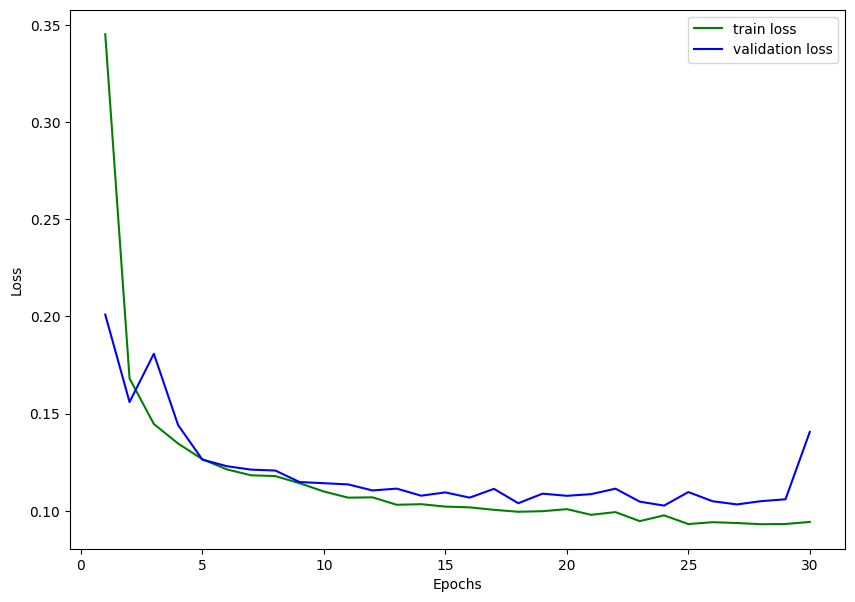

In [ ]:
# grafico loss vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

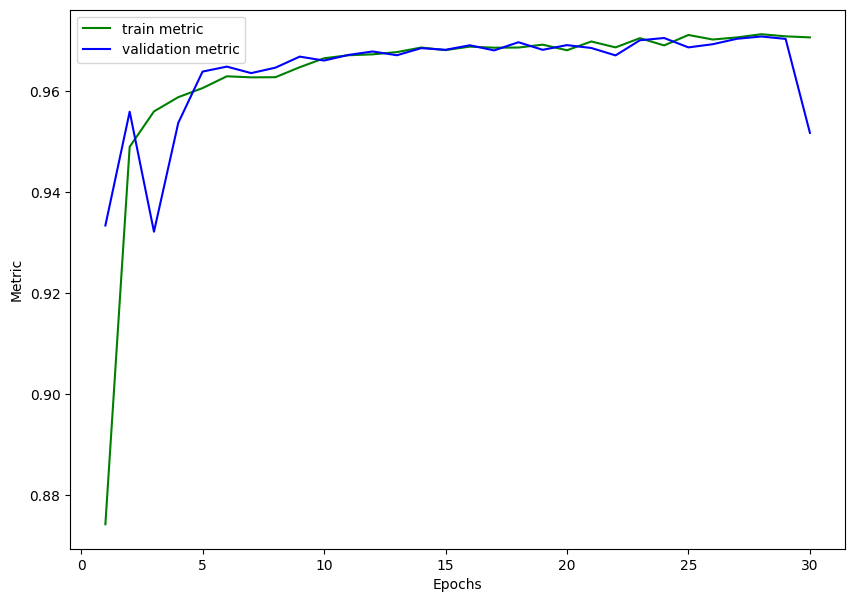

In [ ]:
# grafico accuracy vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
# Salvataggio del modello

torch.save(model, './trained_model.pt')

In [ ]:
# Uso di un modello addestrato in inferenza (predizione)

# lettura del modello

model = torch.load('./trained_model.pt')
model.eval() #va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model

model.to(device)
metric_func.to(device)

loss = 0
metric = 0
counter = 0

with torch.no_grad(): #evita che vengano cacolati automaticamente i gradienti
  for xb, yb in dl_cls_test:
    counter += 1
    xb=xb.to(device)
    yb=yb.type(torch.LongTensor).to(device)
    pred = model(xb)

    loss += loss_fun(pred, yb).item()
    metric += metric_fun(pred, yb).item()

  loss /= counter
  metric /= (counter)

print('Test loss/accuracy: ',loss, ' / ', metric)

Test loss/accuracy:  0.4522310009494366  /  0.8201909046692607


In [ ]:
# proviamo ora a risolvere il task di regressione
# possiamo usare lo stesso modello semplicemente cambiando la loss da CrossEnrtopyLoss a MSE (perchè la softmax nn è stata applicata esplictamente nel modello, ma solo nella loss)


model2 = ShallowMLP(input_dim=6, output_dim=1) #6 input feature e 1 target

loss_fun2 = nn.MSELoss() #MSE

lr = 0.001
opt = optim.Adam(model2.parameters(), lr=lr)
model2.to(device)

ShallowMLP(
  (layer1): Linear(in_features=6, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# numero di epoche
epochs = 100

model2, hist_loss2, hist_metric2, hist_vloss2, hist_vmetric2 = train_model(nn_model=model2, criterion=loss_fun2, metric=None, n_epochs=epochs, dl_train=dl_reg_train, dl_vali=dl_reg_vali)

epoch: 1, time(s): 2.9439, train loss: 91170017.793103, vali loss: 67466774.436782
epoch: 2, time(s): 1.7773, train loss: 31560999.212644, vali loss: 10450152.208812
epoch: 3, time(s): 1.7718, train loss: 7710509.521073, vali loss: 5561547.584291
epoch: 4, time(s): 1.7373, train loss: 4340910.400383, vali loss: 3204020.016284
epoch: 5, time(s): 1.6894, train loss: 2580374.151820, vali loss: 1987864.712644
epoch: 6, time(s): 1.7402, train loss: 1635580.222462, vali loss: 1284152.102730
epoch: 7, time(s): 1.9909, train loss: 1042510.751916, vali loss: 804692.633142
epoch: 8, time(s): 2.2874, train loss: 647778.664152, vali loss: 497113.915948
epoch: 9, time(s): 1.7590, train loss: 401925.195402, vali loss: 311454.238506
epoch: 10, time(s): 1.8283, train loss: 251443.490930, vali loss: 194307.412925
epoch: 11, time(s): 1.8207, train loss: 158464.381376, vali loss: 123852.267571
epoch: 12, time(s): 1.8122, train loss: 101661.591520, vali loss: 80088.148976
epoch: 13, time(s): 1.7016, train

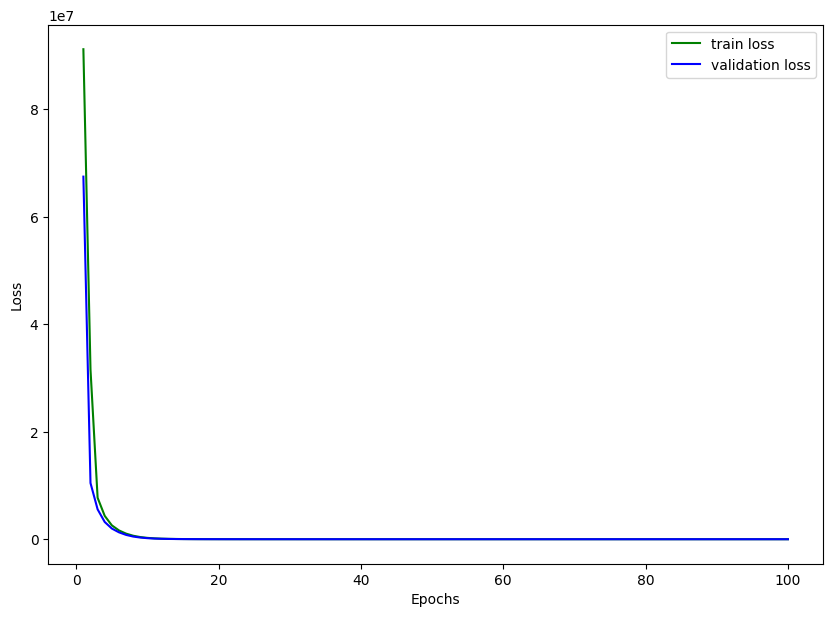

In [ ]:
# grafico MSE vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss2)+1), hist_loss2, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss2)+1), hist_vloss2, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

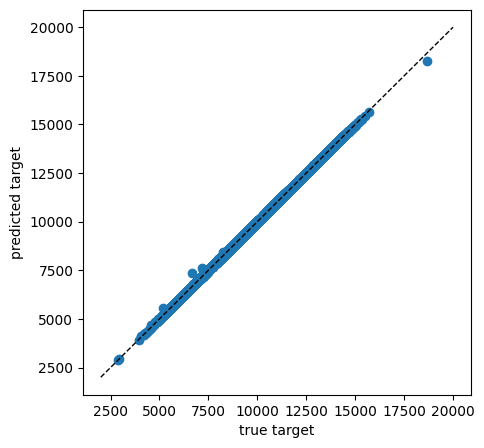

In [ ]:
# plot predicted vs target

model2.eval() #va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model
model2.to('cpu')

loss = 0
metric = 0

true_target=torch.empty(0)
predicted_target=torch.empty(0)

with torch.no_grad(): #evita che vengano cacolati automaticamente i gradienti
  for xb, yb in dl_reg_test:
    pred = model2(xb)
    true_target = torch.cat((true_target, yb), dim=0)
    predicted_target = torch.cat((predicted_target, pred), dim=0)

tr = true_target.numpy()
pr = predicted_target.numpy()

#tr2 = tr[tr<20000]
#pr2 = pr[tr<20000]

tr2 = tr
pr2 = pr

plt.figure(figsize=(5,5))
plt.scatter(tr2, pr2)
plt.plot([2000,20000],[2000,20000], color='black', linewidth=1, linestyle='dashed')
plt.xlabel('true target')
plt.ylabel('predicted target')
plt.show()

In [ ]:
np.max(true_target.numpy())

1999680100.0

### Compiti:


*   giocate con il codice e i parametri per capire come funziona il tutto, diminuite il numero di neuroni del layer hidden, come decadono le prestazioni della rete in termini di accuracy?
*   provare a cambiare l'attivazione del layer hidden della rete da ReLU a F.tanh o F.sigmoid
*   provare ad aggiungere un secondo e un terzo layer hidden alla rete con 512 neuoroni, come cambiano le prestazioni?
*   provare a giocare con la batch size
*   provare ad eliminare il momentum dall'ottmizzatore SGD e provare diversi valori del learning rate da 0.1 a 0.0001 cosa cambia?
*   provare a cambiare la funzione di ottimizzazione, usando *torch.optim.Adam* con parametri di default, cosa cambia?

